In [1]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np

#%pip install tensorflow
import tensorflow as tf


/Users/pascalcsukovits/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/pascalcsukovits/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print(tf.__version__)
print(shap.__version__)
print(np.__version__)

2.16.1
0.45.1
1.26.4


In [3]:
df = pd.read_csv('data/finance_stocks/finance_stocks-train-cleaned.csv')
print('Dataset size:',df.shape)
print('Dataset columns:',df.columns)
df.info()
df.head()


Dataset size: (22383, 11)
Dataset columns: Index(['timestamp', 'tweet_text', 'tweet_url', 'tweet_type', 'price_of_ticker',
       'change_of_ticker', 'tickers_mentioned', 'category', 'clean_tweet_text',
       'Tweet_lemmatized', 'stemmed_text'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22383 entries, 0 to 22382
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   timestamp          14363 non-null  object
 1   tweet_text         20899 non-null  object
 2   tweet_url          22383 non-null  object
 3   tweet_type         22383 non-null  object
 4   price_of_ticker    22383 non-null  object
 5   change_of_ticker   22383 non-null  object
 6   tickers_mentioned  22383 non-null  object
 7   category           22383 non-null  object
 8   clean_tweet_text   20895 non-null  object
 9   Tweet_lemmatized   22383 non-null  object
 10  stemmed_text       20895 non-null  object
dtypes: obj

,timestamp,tweet_text,tweet_url,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,category,clean_tweet_text,Tweet_lemmatized,stemmed_text
0,2023-11-15T09:36:42.028000+00:00,$GOLD's Massive Range.\n\nIn the past ~year we...,https://twitter.com/user/status/17247221551437...,tweet,['15.71'],['+3.69%'],['$GOLD'],stock_images,golds massive range past year weve swept lows ...,"['g', 'o', 'l', 'd', 's', ' ', 'm', 'a', 's', ...",gold massiv rang past year weve swept low high...
1,2023-11-15T06:01:59.788000+00:00,RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...,https://twitter.com/user/status/17246687922221...,retweet,['4495.71'],['+1.87%'],['$SPX'],stock_images,rt spx daily chart target bull move mentioned ...,"['r', 't', ' ', 's', 'p', 'x', ' ', 'd', 'a', ...",rt spx daili chart target bull move mention be...
2,2023-11-15T06:01:55.590000+00:00,RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...,https://twitter.com/user/status/17246687824535...,retweet,['15812.473'],['+2.08%'],['$NDX'],stock_images,rt ndx daily chart target bull move mentioned ...,"['r', 't', ' ', 'n', 'd', 'x', ' ', 'd', 'a', ...",rt ndx daili chart target bull move mention be...
3,2023-11-15T06:01:51.329000+00:00,RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...,https://twitter.com/user/status/17246687591081...,retweet,['178.46'],['+5.21%'],['$IWM'],stock_images,rt iwm daily chart target bull move mentioned ...,"['r', 't', ' ', 'i', 'w', 'm', ' ', 'd', 'a', ...",rt iwm daili chart target bull move mention la...
4,2023-11-15T04:01:49.009000+00:00,RT @coiledspringcap: Everyone has been concern...,https://twitter.com/user/status/17246376898767...,retweet,['4495.71'],['+1.87%'],['$SPX'],stock_images,rt everyone concerned concentration stockmarke...,"['r', 't', ' ', 'e', 'v', 'e', 'r', 'y', 'o', ...",rt everyon concern concentr stockmarket well n...


In [4]:
pd.set_option('display.max_rows', None) 
#pd.reset_option('display.max_rows')

In [5]:
df['change_of_ticker'] = df['change_of_ticker'].str.extract(r'([-+]?\d+\.\d+|\d+)')
df['price_of_ticker'] = df['price_of_ticker'].str.extract(r'([-+]?\d+\.\d+|\d+)')
df['tickers_mentioned'] = df['tickers_mentioned'].str.extract(r'(\$[A-Za-z]+)')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')

df = df[['timestamp', 'clean_tweet_text', 'tweet_type', 'price_of_ticker', 'change_of_ticker', 'tickers_mentioned']]
df = df.dropna()
df.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned
0,2023-11-15 09:36:42.028000+00:00,golds massive range past year weve swept lows ...,tweet,15.71,+3.69,$GOLD
1,2023-11-15 06:01:59.788000+00:00,rt spx daily chart target bull move mentioned ...,retweet,4495.71,+1.87,$SPX
2,2023-11-15 06:01:55.590000+00:00,rt ndx daily chart target bull move mentioned ...,retweet,15812.473,+2.08,$NDX
3,2023-11-15 06:01:51.329000+00:00,rt iwm daily chart target bull move mentioned ...,retweet,178.46,+5.21,$IWM
4,2023-11-15 04:01:49.009000+00:00,rt everyone concerned concentration stockmarke...,retweet,4495.71,+1.87,$SPX


In [6]:
tickers_of_interest = ['$SPX', '$COIN', '$QQQ']
filtered_df_plot = df[df['tickers_mentioned'].isin(tickers_of_interest)]

filtered_df_plot = filtered_df_plot.copy()

filtered_df_plot.loc[:, 'change_of_ticker'] = filtered_df_plot['change_of_ticker'].str.replace('+', '').astype(float)


In [7]:
filtered_df_plot.set_index('timestamp', inplace=True)

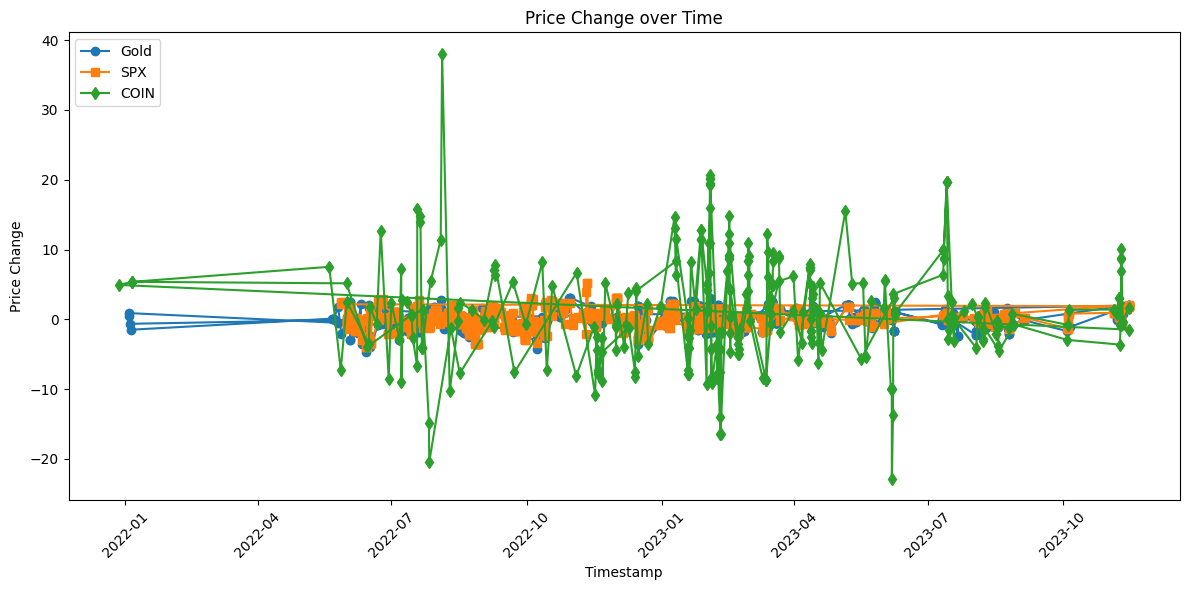

In [8]:
QQQ = filtered_df_plot['tickers_mentioned'] == '$QQQ'
spx = filtered_df_plot['tickers_mentioned'] == '$SPX'
coin = filtered_df_plot['tickers_mentioned'] == '$COIN'

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(filtered_df_plot[QQQ]["change_of_ticker"], marker='o', linestyle='-', label='Gold')
plt.plot(filtered_df_plot[spx]["change_of_ticker"], marker='s', linestyle='-', label='SPX')
plt.plot(filtered_df_plot[coin]["change_of_ticker"], marker='d', linestyle='-', label='COIN')

plt.title('Price Change over Time')
plt.ylabel('Price Change')
plt.xlabel('Timestamp')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

 Simple LSTM (Long Short-Term Memory) model for predicting stock prices

In [9]:
#%pip install tf-keras

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline

In [10]:
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [11]:
predictions = [pipe(text)[0]['label'] for text in df["clean_tweet_text"]]
df['Sentiment'] = predictions

In [12]:
df.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,Sentiment
0,2023-11-15 09:36:42.028000+00:00,golds massive range past year weve swept lows ...,tweet,15.71,+3.69,$GOLD,positive
1,2023-11-15 06:01:59.788000+00:00,rt spx daily chart target bull move mentioned ...,retweet,4495.71,+1.87,$SPX,neutral
2,2023-11-15 06:01:55.590000+00:00,rt ndx daily chart target bull move mentioned ...,retweet,15812.473,+2.08,$NDX,neutral
3,2023-11-15 06:01:51.329000+00:00,rt iwm daily chart target bull move mentioned ...,retweet,178.46,+5.21,$IWM,neutral
4,2023-11-15 04:01:49.009000+00:00,rt everyone concerned concentration stockmarke...,retweet,4495.71,+1.87,$SPX,neutral


In [13]:
df['change_of_ticker_increases'] = df['change_of_ticker'].str.startswith('+').replace({True: '1', False: '0'})
df_pred = df
df_pred['change_of_ticker'] = df_pred['change_of_ticker'].str.replace('[+|-]', '', regex=True).astype(float)

In [14]:
print(df_pred.isnull().sum())
#df_pred = df_pred.dropna()
df_pred.head()


timestamp                     0
clean_tweet_text              0
tweet_type                    0
price_of_ticker               0
change_of_ticker              0
tickers_mentioned             0
Sentiment                     0
change_of_ticker_increases    0
dtype: int64


,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,Sentiment,change_of_ticker_increases
0,2023-11-15 09:36:42.028000+00:00,golds massive range past year weve swept lows ...,tweet,15.71,3.69,$GOLD,positive,1
1,2023-11-15 06:01:59.788000+00:00,rt spx daily chart target bull move mentioned ...,retweet,4495.71,1.87,$SPX,neutral,1
2,2023-11-15 06:01:55.590000+00:00,rt ndx daily chart target bull move mentioned ...,retweet,15812.473,2.08,$NDX,neutral,1
3,2023-11-15 06:01:51.329000+00:00,rt iwm daily chart target bull move mentioned ...,retweet,178.46,5.21,$IWM,neutral,1
4,2023-11-15 04:01:49.009000+00:00,rt everyone concerned concentration stockmarke...,retweet,4495.71,1.87,$SPX,neutral,1


In [24]:
df_pred_model = df_pred[df_pred['tickers_mentioned'] == '$SPX']
df_pred_model.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,Sentiment,change_of_ticker_increases,Sentiment_numeric
1,2023-11-15 06:01:59.788000+00:00,rt spx daily chart target bull move mentioned ...,retweet,4495.71,1.87,$SPX,neutral,1,0
4,2023-11-15 04:01:49.009000+00:00,rt everyone concerned concentration stockmarke...,retweet,4495.71,1.87,$SPX,neutral,1,0
5,2023-11-15 04:01:44.817000+00:00,rt spx equal weight breaking consolidation see...,retweet,4495.71,1.87,$SPX,neutral,1,0
6,2023-11-15 04:01:40.263000+00:00,rt spx remained extended bwave secondary termi...,retweet,4495.71,1.87,$SPX,positive,1,1
36,2023-11-14 17:21:39.575000+00:00,michael burry closed billion nq spx short posi...,quote tweet,4488.5,1.71,$SPX,negative,1,-1


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression


df_pred_model['Sentiment_numeric'] = df_pred_model['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

transformers = [
    ('text', TfidfVectorizer(max_features=1000), 'clean_tweet_text'),  
    ('numeric', 'passthrough', ['Sentiment_numeric', 'price_of_ticker']) 
]

preprocessor = ColumnTransformer(transformers)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

X = df[['clean_tweet_text', 'Sentiment_numeric', 'price_of_ticker']]
y = df['change_of_ticker_increases'].astype(int) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test.astype(int), y_pred_binary)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5749822316986496


/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_8205/4291980229.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_model['Sentiment_numeric'] = df_pred_model['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})


In [26]:
new_text = "golds massive range past year weve swept"
new_sentiment = 1
new_price = 13

new_instance_data = pd.DataFrame({
    'clean_tweet_text': [new_text],
    'Sentiment_numeric': [new_sentiment],
    'price_of_ticker': [new_price]
})

prediction = pipeline.predict(new_instance_data)
print(f"Predicted change of ticker: {prediction[0]}")

Predicted change of ticker: 0.6201586870659144


SHAP

In [18]:
#df_shap = ≈[:10]

#explainer = shap.Explainer(pipe)
#shap_values = explainer(df_shap["clean_tweet_text"])

In [19]:
#shap.plots.bar(shap_values[:, :, "positive"].mean(0), order=shap.Explanation.argsort)

In [20]:
#Bias in stock market data

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from nltk.tokenize import word_tokenize
import re

vectorizer = TfidfVectorizer(max_features=1000) 
X = vectorizer.fit_transform(df_pred_model['clean_tweet_text'])
y = df_pred_model['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6515151515151515
Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.37      0.46        30
     neutral       0.69      0.89      0.78        66
    positive       0.55      0.44      0.49        36

    accuracy                           0.65       132
   macro avg       0.62      0.57      0.58       132
weighted avg       0.64      0.65      0.63       132

